In [3]:
from constants import DECK, DECK_DICT, HOLE_CARDS, HOLE_CARD_DICT
import pandas as pd
import numpy as np
from simulation import simulate_hand
from itertools import combinations, product
from utils import card_distance, Card, Hand
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
class PokerDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        attributes = [row['suited'], row['connectedness'], row['pair']]
        hand_idx = row['hand_idx']
        win_percentage = row['river_win_rate']*100
        return (
            torch.tensor(hand_idx, dtype=torch.long),
            torch.tensor(attributes, dtype=torch.float32), 
            torch.tensor(win_percentage, dtype=torch.float32)
            )

In [123]:
dataset = PokerDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [164]:
class CardEmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=16):
        super().__init__()
        self.embedder = nn.Embedding(169, embedding_dim)
    def forward(self, x):
        x_embed = self.embedder(x)
        return x_embed

class HandWinPredictor(nn.Module):
    def __init__(self, card_embedding_dim=16, hidden_dims=[128, 64, 32]):
        super(HandWinPredictor, self).__init__()
        
        self.encoder = CardEmbeddingModel(card_embedding_dim)
        
        layers = []
        prev_dim = card_embedding_dim + 3
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.LeakyReLU())
            layers.append(nn.BatchNorm1d(dim))
            prev_dim = dim
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        # self.sigmoid = nn.Sigmoid()
    
    def forward(self, hole_card_idx, hole_card_attributes):
        hole_card_embedding = self.encoder(hole_card_idx)
        x = torch.concat([hole_card_embedding, hole_card_attributes], dim=1)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x #self.sigmoid(x)
        

In [173]:
model = HandWinPredictor(card_embedding_dim=8, hidden_dims=[64, 32, 16])
optimizer = torch.optim.Adam(params=model.parameters(), lr=.001)
loss_fn = nn.MSELoss()
epochs = 125

In [174]:
train_losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        hole_card_idx, hole_card_attributes, targets = batch
        optimizer.zero_grad()
        outputs = model(hole_card_idx, hole_card_attributes)
        loss = loss_fn(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
            
        total_loss += loss.item()
    avg_loss = total_loss/len(dataloader)
    train_losses.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {round(avg_loss, 5)}")
    

Epoch 10/125, Loss: 2433.49845
Epoch 20/125, Loss: 2274.45508
Epoch 30/125, Loss: 2046.32387
Epoch 40/125, Loss: 1782.76039
Epoch 50/125, Loss: 1478.87373
Epoch 60/125, Loss: 1180.79258
Epoch 70/125, Loss: 876.20281
Epoch 80/125, Loss: 612.3826
Epoch 90/125, Loss: 395.82005
Epoch 100/125, Loss: 236.55159
Epoch 110/125, Loss: 142.0395
Epoch 120/125, Loss: 76.06274


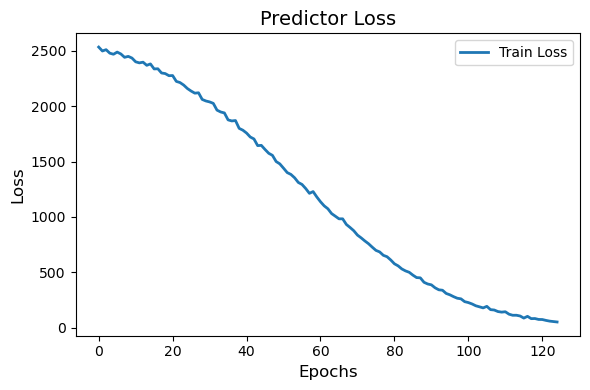

In [175]:
plt.figure(figsize=(6, 4))
sns.lineplot(x=list(range(epochs)), y=train_losses, label="Train Loss", linestyle='-', linewidth=2)
plt.title("Predictor Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10) 
plt.tight_layout()
plt.show()

In [134]:
from sklearn.decomposition import PCA

In [176]:
with torch.no_grad():
    model.eval()
    hand_embedder = model.encoder
    hand_embeddings = hand_embedder(torch.arange(169, dtype=torch.long))

In [177]:
embeddings_np = hand_embeddings.detach().cpu().numpy()
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)

In [178]:
connected_array = df['connectedness'].to_numpy()
pair_array = df['pair'].to_numpy()
suited_array = df['suited'].to_numpy()
hand_strength_array = df['river_win_rate'].to_numpy()

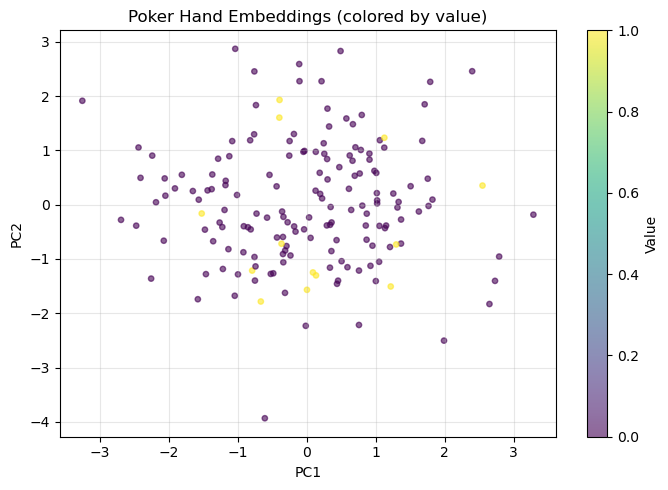

In [182]:
plt.figure(figsize=(7, 5))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=pair_array,
            alpha=0.6, s=15, cmap='viridis')

cbar = plt.colorbar(scatter)
cbar.set_label('Value')
plt.title("Poker Hand Embeddings (colored by value)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.tight_layout()